<a href="https://colab.research.google.com/github/iamviji/project/blob/master/archive/End2EndQPSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 317 (delta 60), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (317/317), 26.06 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (150/150), done.
project  sample_data
EncoderModulatorSplitArch.ipynb		MainModelModCodingConstEnergy.ipynb
EncoderOutputExperiment.ipynb		MainModelModCoding.ipynb
EncoderWithoutNormalizationLayer.ipynb	MainModelOneHotMethod.ipynb
End2End8PSK.ipynb			MainModelOneHotMethodSoftMax.ipynb
End2EndOneHotQPSK.ipynb			MainModelOneHotModCoding.ipynb
End2EndQPSK.ipynb			MainModelWithSingleBERTraining.ipynb
End2EndQPSKRegularized.ipynb		misc
MainModel.ipynb				README.md
MainModelKeras.ipynb			util.py
MainModelKerasOneHot.ipynb
     |████████████████████████████████| 1.1MB 4.6MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=ce7db21855ead689a4

In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 1 0 ... 0 0 1]
 [0 0 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [1 1 0 ... 1 0 0]
 [1 0 1 ... 0 1 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.54s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.23s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.75s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.37s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 15.90s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.64s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.06s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.59s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 13.54s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.13s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.20s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.38s
SNR: 1.000:
 -> BER: 0.48
 -> Total Time: 10.69s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.89s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.75s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.36s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.78s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.07s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.65s
SNR: 0.000:
 -> BER: 0.58
 -> Total Time: 13.86s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.10s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.28s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.53s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.68s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 11.58s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.93s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.80s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.81s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 9.52s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.74s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.54s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.45s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.86s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.26s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.83s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 14.40s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.12s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.35s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.51s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 11.07s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.96s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.93s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.95s
SNR: 1.000:
 -> BER: 0.48
 -> Total Time: 9.84s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.42s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

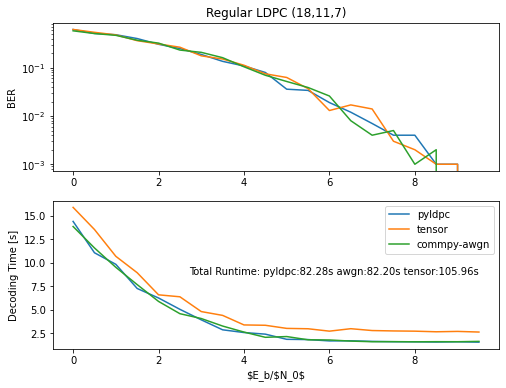

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [10]:
#18/9 = 2 bit per symbol => QPSK
num_of_channel = 9 
input_message_length = 11
encoder_output_length = 18

In [11]:
# Define Model 

# input_message_length is initialized by ldpc encoder

print ("input_message_length=", input_message_length)
print ("num_of_channel=", num_of_channel)
print ("encoder_output_length=", encoder_output_length)

num_of_hidden_layer_node = encoder_output_length

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_of_hidden_layer_node], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, num_of_channel * 2], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_channel * 2, num_of_hidden_layer_node], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, num_of_hidden_layer_node], -1, 1), name="decoder_l2_weights"),
  "decoder_l3" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, input_message_length], -1, 1), name="decoder_l3_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_channel * 2], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="decoder_l2_bias"),
  "decoder_l3" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l3_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  #layer_2 = layer_1
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_2), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

#input_channel_x = tf.placeholder("float32", [None, 3], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x
def dl_decoder (x):
  layer_1 = (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  layer_3 = tf.nn.sigmoid(tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  #layer_3 = tf.nn.sigmoid (tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  return layer_3

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
#loss1 = tf.losses.sigmoid_cross_entropy(multi_class_labels=input_message_x,logits=dl_decoder_output)
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=0.00007).minimize (loss1)
rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

input_message_length= 11
num_of_channel= 9
encoder_output_length= 18


In [12]:
awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

In [13]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[1 0 1 ... 1 1 1]
 [1 1 1 ... 1 0 1]
 [0 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 0 1]
 [0 0 1 ... 0 1 0]
 [1 1 1 ... 1 0 0]]
10000


In [14]:
class GetOutOfLoop( Exception ):
    pass

batch_size = 500


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 130
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 1
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma) 
      if (snr < 6): opt = rms_optimizer1
      else : opt = rms_optimizer 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
          x_train_batch_float = x_train_batch.astype("float32")
          _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
          if (l < 0.5): lrate = 0.001
          if (l < 0.25): lrate = 0.00001
          if (l < 0.1): lrate = 0.0000001
          if (l < 0.07): lrate = 0.0000001
          if j % display_step == 0:
            print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))
          #if (l < 0.005): raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

batch_size: 500 num_of_batcches: 20.0
Training for SNR= 0.0  sigma= 1.0
Step 64935: Minibatch Loss: 1.293048
Step 64935: Minibatch Loss: 1.264799
Step 64935: Minibatch Loss: 1.255642
Step 64935: Minibatch Loss: 1.247981
Step 64935: Minibatch Loss: 1.207918
Step 64935: Minibatch Loss: 1.169476
Step 64935: Minibatch Loss: 1.173063
Step 64935: Minibatch Loss: 1.178727
Step 64935: Minibatch Loss: 1.153383
Step 64935: Minibatch Loss: 1.131616
Step 64935: Minibatch Loss: 1.120601
Step 64935: Minibatch Loss: 1.102437
Step 64935: Minibatch Loss: 1.070969
Step 64935: Minibatch Loss: 1.051402
Step 64935: Minibatch Loss: 1.037470
Step 64935: Minibatch Loss: 1.050194
Step 64935: Minibatch Loss: 1.010970
Step 64935: Minibatch Loss: 1.009667
Step 64935: Minibatch Loss: 1.004929
Step 64935: Minibatch Loss: 1.005438
Step 64935: Minibatch Loss: 0.965184
Step 64935: Minibatch Loss: 0.968102
Step 64935: Minibatch Loss: 0.963846
Step 64935: Minibatch Loss: 0.941473
Step 64935: Minibatch Loss: 0.961506
Ste

In [15]:
#a = [[1,2],[3,4]]
#x=a/numpy.sqrt(numpy.sum(numpy.square(a),axis=1).reshape([2,1]))
#print (x)
#print (1/numpy.sqrt(5))
#print (x[0][0]**2+x[0][1]**2)

#input_channel_x = tf.placeholder("float32", [None, 2], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x

#ans=train_sess.run ([l], feed_dict={input_channel_x:a})
#print (ans)

#print (ans[0][0]**2+ans[0][1]**2)

In [16]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

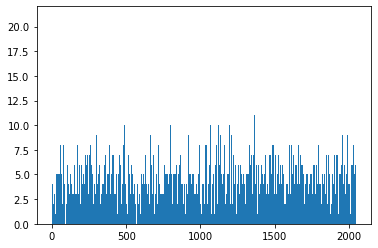

In [17]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

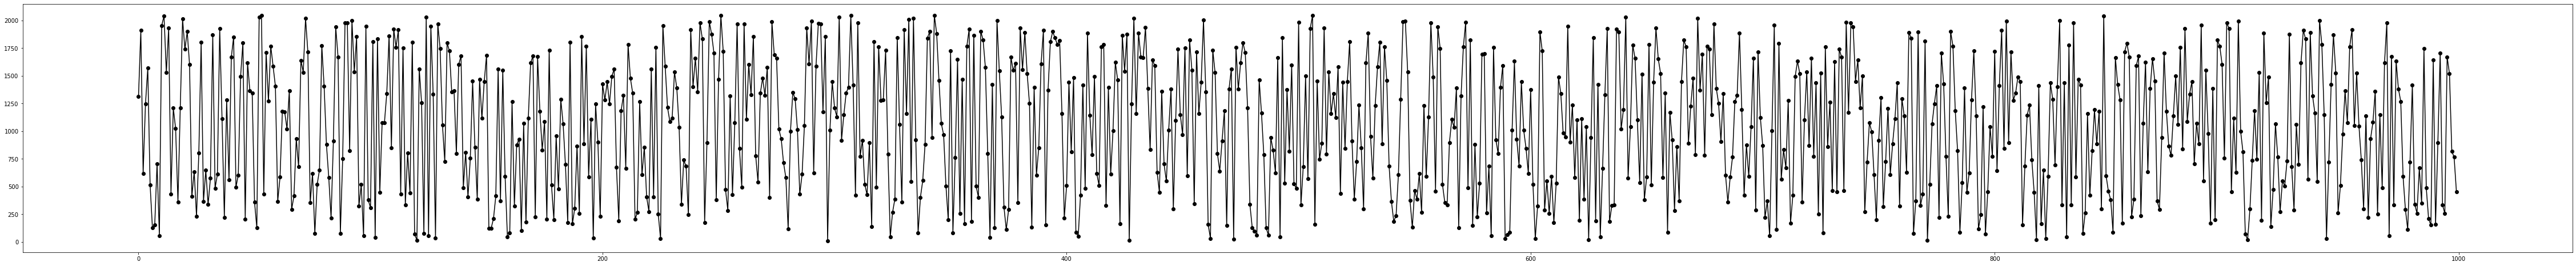

In [18]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [19]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 10
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
data_category = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    data_category.append (training_input_message_decimal [i:i+1][0])
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_in.append(encoded_message[0][0])    
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0])    
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.33s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.59s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.88s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.14s
SNR: 0.000:
 -> BER: 0.69
 -> Total Time: 2.94s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.52s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.79s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.05s
SNR: 0.500:
 -> BER: 0.64
 -> Total Time: 2.62s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.77s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.03s
SNR: 1.000:
 -> BER: 0.60
 -> Total Time: 2.58s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

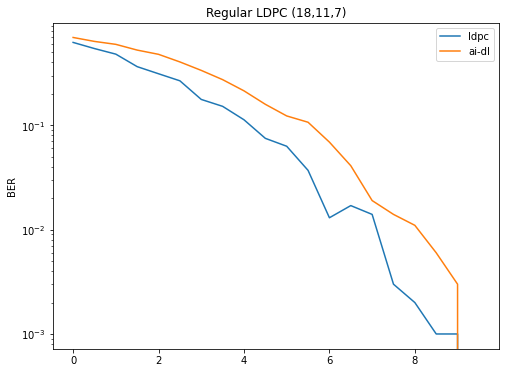

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()

In [21]:
ch1_x = []
ch1_y = []
ch2_x = []
ch2_y = []
ch3_x = []
ch3_y = []
for c in channel_in:
  ch1_x.append (c[0])
  ch1_y.append (c[1])
  ch2_x.append (c[2])
  ch2_y.append (c[3])
  ch3_x.append (c[4])
  ch3_y.append (c[5])


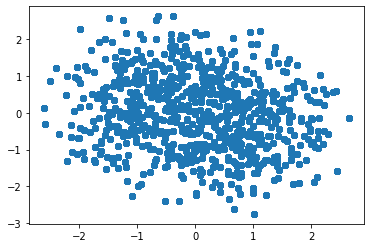

In [22]:
import matplotlib.pyplot as plt


plt.scatter(ch1_x, ch1_y)

plt.show()

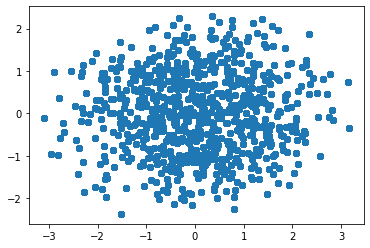

In [23]:
import matplotlib.pyplot as plt


plt.scatter(ch2_x, ch2_y)

plt.show()

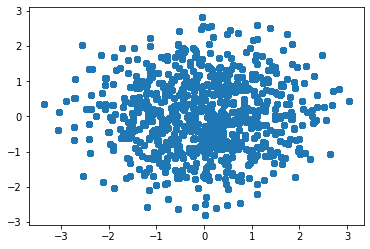

In [24]:

plt.scatter(ch3_x, ch3_y)

plt.show()

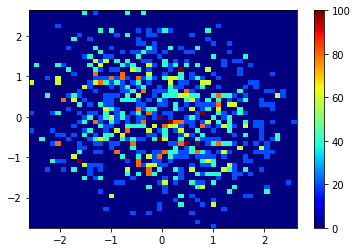

In [25]:
import matplotlib.pyplot as plt

plt.hist2d(ch1_x, ch1_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

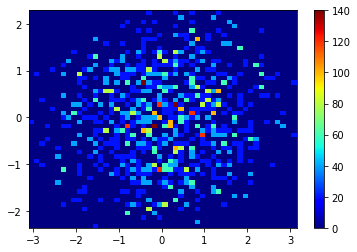

In [26]:
import matplotlib.pyplot as plt

plt.hist2d(ch2_x, ch2_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [27]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn

channel_in_embedded = TSNE(n_components=2).fit_transform(channel_in)

tsne_df = pd.DataFrame({'X':channel_in_embedded[:,0],
                        'Y':channel_in_embedded[:,1],
                        'value':data_category})

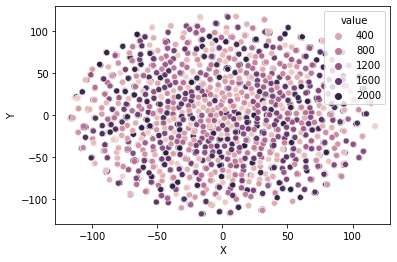

In [28]:
#seaborn.scatterplot(channel_in_embedded[:,0], channel_in_embedded[:,1],hue=data_category, legend='full', palette=['purple','red','orange','brown','blue','dodgerblue','green','lightgreen','darkcyan', 'black'])
#print (data_category)
#palette = seaborn.color_palette("bright", 2**input_message_length)

seaborn.scatterplot(x="X", y="Y", hue="value",  data=tsne_df)


In [29]:
testing_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


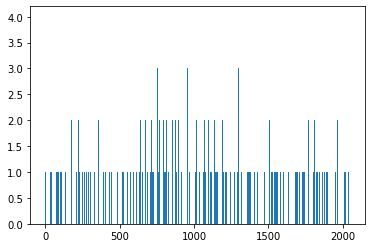

In [30]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
testing_input_message_decimal = row_bits2int(testing_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(testing_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(testing_input_message_decimal, bins = x_axis) 
plt.show()

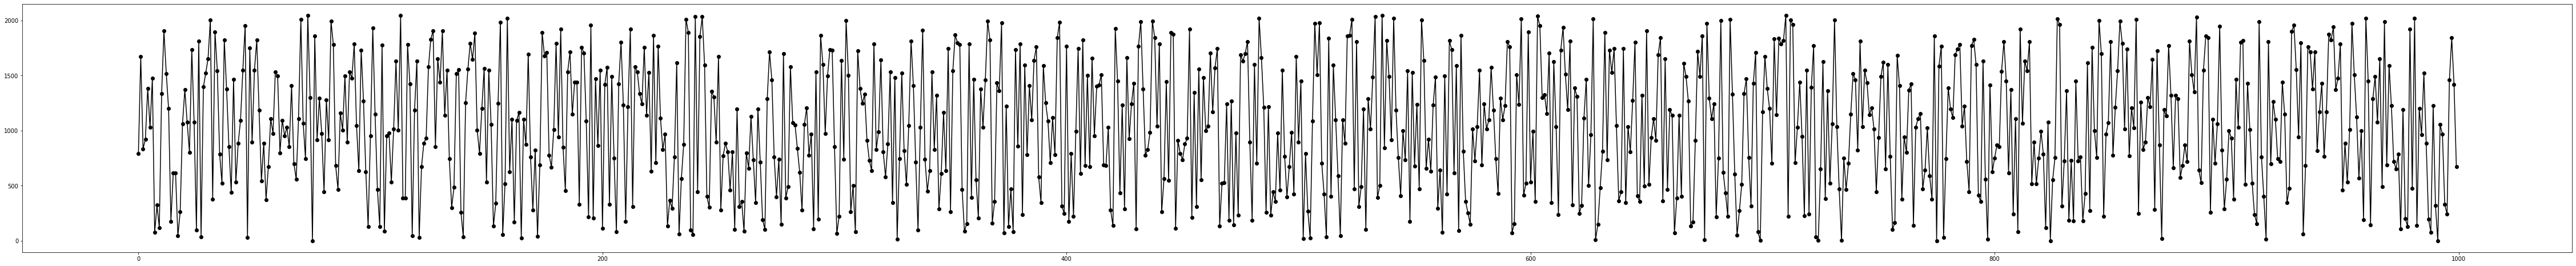

In [31]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],testing_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [32]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = testing_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-testing_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.34s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.63s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.89s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.15s
SNR: 0.000:
 -> BER: 0.70
 -> Total Time: 3.00s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.81s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.08s
SNR: 0.500:
 -> BER: 0.62
 -> Total Time: 2.71s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.08s
SNR: 1.000:
 -> BER: 0.57
 -> Total Time: 2.72s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

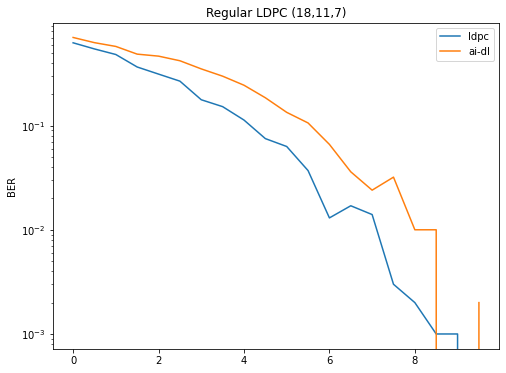

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(num_of_channel * 2,input_message_length,num_of_channel * 2-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(num_of_channel * 2,input_message_length))
plt.legend ()
plt.show()